In [107]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from captum.attr import IntegratedGradients, LayerIntegratedGradients
from tqdm import tqdm

In [93]:
torch.cuda.is_available()

True

In [3]:
class SequenceDataset(Dataset):
    def __init__(self, df, exog_col='exog', endog_col='endog'):
        """
        df: a pandas DataFrame with two columns:
            - exog_col: list of integers (sequence)
            - endog_col: binary label (0 or 1)
        """
        self.sequences = df[exog_col].tolist()
        self.labels = df[endog_col].tolist()

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [4]:
def collate_fn(batch):
    """
    Pads sequences in a batch to the same length.
    """
    # Separate sequences and labels
    sequences, labels = zip(*batch)

    # Find max length within this batch
    max_length = max(len(seq) for seq in sequences)

    # Pad sequences with 0 (or a special PAD token id if you have one)
    padded_sequences = []
    for seq in sequences:
        padded = seq + [34]*(max_length - len(seq))
        padded_sequences.append(padded)

    # Convert to tensors
    padded_sequences = torch.tensor(padded_sequences, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.float)

    return padded_sequences, labels

In [5]:
class TransformerBinaryClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_dim=64,
        num_heads=2,
        num_layers=2,
        ff_dim=128,
        dropout=0.1
    ):
        """
        vocab_size: size of the vocabulary (max integer token + 1).
        embed_dim: embedding dimension.
        num_heads: number of attention heads in the MultiheadAttention.
        num_layers: number of transformer encoder layers to stack.
        ff_dim: hidden dim in the feed-forward network of each encoder layer.
        dropout: dropout probability.
        """
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Positional encoding (optional). If sequences can be very long,
        # consider a standard sinusoidal positional encoding approach.
        # Here we just show a simple learned positional embedding for demonstration:
        self.pos_embedding = nn.Embedding(5000, embed_dim)  # 5000 is arbitrary

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True  # ensures shape is (batch, seq, embed_dim)
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.classifier = nn.Linear(embed_dim, 1)  # single output for binary

    def forward(self, x):
        """
        x: [batch_size, seq_len] of token IDs
        """
        batch_size, seq_len = x.shape

        # Token embeddings
        token_embeddings = self.embedding(x)  # [batch_size, seq_len, embed_dim]

        # Positional embeddings (very simple version)
        positions = torch.arange(0, seq_len, device=x.device).unsqueeze(0)  # [1, seq_len]
        pos_embeddings = self.pos_embedding(positions)  # [1, seq_len, embed_dim]

        # Combine token and positional embeddings
        embeddings = token_embeddings + pos_embeddings

        # Transformer Encoder
        encoder_output = self.transformer_encoder(embeddings)  
        # [batch_size, seq_len, embed_dim]

        # For classification, we often just take the output at the last token
        # or the pooled [CLS] representation if we have one. Another approach:
        # do a mean or max pooling across seq_len.
        # We'll do mean pooling across the sequence dimension:
        pooled_output = encoder_output.mean(dim=1)  # [batch_size, embed_dim]

        # Final linear layer -> raw logits
        logits = self.classifier(pooled_output).squeeze(-1)  # [batch_size]

        return logits

In [29]:
def train_model(
    model, 
    train_loader, 
    val_loader, 
    num_epochs=5, 
    lr=1e-3, 
    device='cuda'
):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # GradScaler for scaling loss in mixed precision
    scaler = GradScaler()
    
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        total_acc = 0.0
        total_count = 0

        for sequences, labels in train_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass under autocast
            # You can optionally set the precision as fp16 or bfloat16 below
            # with autocast(device_type='cuda', dtype=torch.bfloat16):
            with autocast():
                logits = model(sequences)
                loss = criterion(logits, labels)

            # Backward pass with GradScaler
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Compute training accuracy
            preds = torch.sigmoid(logits)
            preds_class = (preds >= 0.5).float()
            acc = (preds_class == labels).float().sum()

            # Accumulate metrics
            batch_size = sequences.size(0)
            total_loss += loss.item() * batch_size
            total_acc += acc.item()
            total_count += batch_size

        avg_train_loss = total_loss / total_count
        avg_train_acc = total_acc / total_count
        
        # Evaluate on validation set (optionally also under autocast)
        val_loss, val_acc = evaluate_model(model, val_loader, device, criterion)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

In [7]:
def evaluate_model(model, data_loader, device, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    total_count = 0

    with torch.no_grad():
        # with autocast(device_type='cuda'):
        for sequences, labels in data_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)

            logits = model(sequences)
            loss = criterion(logits, labels)

            preds = torch.sigmoid(logits)
            preds_class = (preds >= 0.5).float()
            acc = (preds_class == labels).float().sum()

            batch_size = sequences.size(0)
            total_loss += loss.item() * batch_size
            total_acc += acc.item()
            total_count += batch_size

    avg_loss = total_loss / total_count
    avg_acc = total_acc / total_count
    return avg_loss, avg_acc


In [73]:
def evaluate_on_test_set(model, test_loader, device='cuda'):
    """
    Generates predictions on the test set, then plots the ROC curve and prints the AUC.
    """
    model.eval()
    
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(sequences)
            # Convert logits -> probabilities in [0, 1]
            probs = torch.sigmoid(logits)

            # Collect results for ROC
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {:.3f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal for reference
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Test Set ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    print(f"Test AUC: {roc_auc:.3f}")

    return roc_auc, all_labels, all_probs

# Load and split

In [52]:
load = pd.read_csv('full_hands_df.csv')
load['seq'] = load['seq'].apply(ast.literal_eval)

In [53]:
load = load[['seq','is_chiitoi']]
load = load.rename(columns={'seq':'exog','is_chiitoi':'endog'})

In [54]:
load.shape

(210550, 2)

In [55]:
df = load.copy()

In [56]:
train, test = train_test_split(df, test_size=0.2)

train, val = train_test_split(train, test_size=0.1)

In [127]:
train.to_csv('run_3_11_2025/train.csv')
test.to_csv('run_3_11_2025/test.csv')
val.to_csv('run_3_11_2025/val.csv')

In [57]:
val.shape

(16844, 2)

# Train

In [58]:
train_dataset = SequenceDataset(train)
val_dataset = SequenceDataset(val)
test_dataset =  SequenceDataset(test)

In [101]:
train_loader = DataLoader(train_dataset, 
                          batch_size=8192, 
                          shuffle=True, 
                          collate_fn=collate_fn,
                          num_workers=8,
                          pin_memory=True)

val_loader = DataLoader(val_dataset, 
                        batch_size=8192, 
                        shuffle=False, 
                        collate_fn=collate_fn,
                        num_workers=8,
                        pin_memory=True)

test_loader = DataLoader(test_dataset, 
                         batch_size=512, 
                         shuffle=False, 
                         collate_fn=collate_fn)

In [60]:
vocab_size = 35

In [61]:
device = torch.device("cuda")

In [65]:
model = TransformerBinaryClassifier(
    vocab_size=vocab_size,
    embed_dim=32,
    num_heads=2,
    num_layers=10,
    ff_dim=64,
    dropout=0.1
)

In [68]:
train_model(model, train_loader, val_loader, num_epochs=30, lr=1e-3, device=device)

/tmp/ipykernel_1580/49820654.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_1580/49820654.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/30] Train Loss: 0.0853, Train Acc: 0.9831, Val Loss: 0.0932, Val Acc: 0.9802
Epoch [2/30] Train Loss: 0.0820, Train Acc: 0.9831, Val Loss: 0.0913, Val Acc: 0.9802
Epoch [3/30] Train Loss: 0.0809, Train Acc: 0.9831, Val Loss: 0.0945, Val Acc: 0.9802
Epoch [4/30] Train Loss: 0.0806, Train Acc: 0.9831, Val Loss: 0.0898, Val Acc: 0.9802
Epoch [5/30] Train Loss: 0.0796, Train Acc: 0.9831, Val Loss: 0.0892, Val Acc: 0.9802
Epoch [6/30] Train Loss: 0.0787, Train Acc: 0.9831, Val Loss: 0.0884, Val Acc: 0.9802
Epoch [7/30] Train Loss: 0.0783, Train Acc: 0.9831, Val Loss: 0.0882, Val Acc: 0.9802
Epoch [8/30] Train Loss: 0.0779, Train Acc: 0.9831, Val Loss: 0.0877, Val Acc: 0.9801
Epoch [9/30] Train Loss: 0.0776, Train Acc: 0.9830, Val Loss: 0.0878, Val Acc: 0.9802
Epoch [10/30] Train Loss: 0.0775, Train Acc: 0.9831, Val Loss: 0.0871, Val Acc: 0.9802
Epoch [11/30] Train Loss: 0.0771, Train Acc: 0.9831, Val Loss: 0.0882, Val Acc: 0.9802
Epoch [12/30] Train Loss: 0.0771, Train Acc: 0.9831,

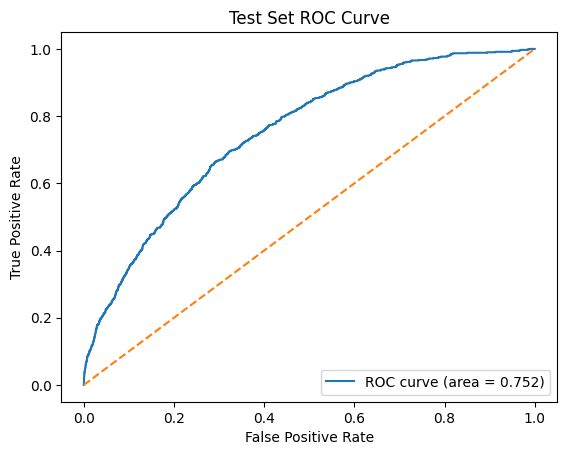

Test AUC: 0.752
Test AUC: 0.7521308862769939


In [74]:
model.to(device)
test_auc, labels, probs = evaluate_on_test_set(model, test_loader, device=device)
print("Test AUC:", test_auc)

In [72]:
test_auc

np.float64(0.7521308862769939)

In [71]:
torch.save(model, f'models/{test_auc}.pth')

# Tune?

# Explainability

In [75]:
df = pd.DataFrame({'labels': labels, 'probabilities': probs})

In [77]:
test

,exog,endog
141675,"[1, 0, 7, 0, 13, 27, 26, 9, 8, 7, 33, 28]",0
36486,"[1, 0, 5, 0, 3, 29, 33, 8, 3, 21]",0
156052,"[1, 0, 7, 0, 3, 18, 28, 2, 31, 7, 30, 19]",0
158657,"[0, 1, 3, 0, 9, 26, 8, 7]",0
209151,"[1, 0, 5, 0, 30, 18, 9, 9, 31, 27]",0
...,...,...
181796,"[1, 1, 10, 0, 18, 9, 26, 24, 26, 1, 33, 4, 6, ...",0
123005,"[0, 0, 12, 0, 18, 28, 28, 29, 33, 30, 32, 1, 2...",0
27216,"[2, 0, 16, 0, 9, 30, 32, 32, 31, 2, 29, 27, 19...",0
76288,"[1, 1, 6, 0, 5, 31, 26, 18, 9, 9, 23]",0


In [81]:
test_res = df.merge(test.reset_index(), left_index=True, right_index=True)

In [91]:
test_res.sort_values('probabilities', ascending=False)[['exog','endog','probabilities']].to_csv('sorted_hands.csv')

## Integrated Gradients

In [117]:
model.eval()
model.to(device)

lig = LayerIntegratedGradients(model.forward, model.embedding)

for inputs, labels in test_loader:
    # Make sure inputs are integer token IDs
    inputs = inputs.to(device, dtype=torch.long)
    labels = labels.to(device)

    # Create a baseline of the same shape as 'inputs' but with a special ID
    # For instance, if 0 is a valid "pad" or "neutral" token in your vocabulary:
    baseline_tokens = torch.zeros_like(inputs)  
    # shape: [batch_size, seq_len], dtype: long

    # Now do the attribution. The shape & dtype of `baseline_tokens` matches `inputs`.
    # Captum will call model.embedding() on each interpolation step from these 
    # baseline token IDs to the real token IDs. 
    attributions = lig.attribute(
        inputs=inputs,               # shape [batch_size, seq_len], long
        baselines=baseline_tokens,   # same shape, also long
        n_steps=50,                  # number of interpolation steps
        target=None                  # single-logit output => None or 0
    )
    # attributions will have shape [batch_size, seq_len, embed_dim]

    # Move attributions to CPU to analyze
    attributions = attributions.detach().cpu()
    # Optionally sum across embedding dimensions for a single value per token
    attributions_per_token = attributions.sum(dim=-1).numpy()  # shape [batch_size, seq_len]

    # Example: examine the first item
    idx = 0
    token_ids = inputs[idx].detach().cpu().numpy()  # shape [seq_len]
    token_scores = attributions_per_token[idx]      # shape [seq_len]

    # Zip and sort by absolute score
    pairs = list(zip(token_ids, token_scores))
    display(pd.DataFrame(pairs))

    break  # just do one batch for demonstration

,0,1
0,1,0.686886
1,0,0.000000
2,7,0.033814
3,0,0.000000
4,13,0.472491
5,27,-0.563150
6,26,-0.029665
7,9,-0.198221
8,8,-0.333449
9,7,1.612909


In [121]:
idx = 4
token_ids = inputs[idx].detach().cpu().numpy()  # shape [seq_len]
token_scores = attributions_per_token[idx]      # shape [seq_len]
# Zip and sort by absolute score
pairs = list(zip(token_ids, token_scores))
display(pd.DataFrame(pairs))

,0,1
0,1,0.346319
1,0,0.000000
2,5,-0.213944
3,0,0.000000
4,30,-0.084801
5,18,0.031815
6,9,-0.300950
7,9,-0.179466
8,31,-0.270498
9,27,-0.125803


In [125]:
attributions_per_token

array([[ 0.68688627,  0.        ,  0.03381367, ..., -0.33118418,
        -0.94746743, -0.25505017],
       [-0.04315179,  0.        , -0.07344268, ..., -0.24468354,
        -0.26974552, -0.13630669],
       [ 0.35888357,  0.        ,  0.04341041, ..., -0.42681857,
        -0.56727663, -0.36257071],
       ...,
       [ 0.        ,  0.        ,  0.16753596, ..., -0.3601254 ,
        -0.27239071, -0.2039411 ],
       [ 0.21222255, -0.02096207, -0.05771243, ..., -0.38903683,
        -0.29965485, -0.13832357],
       [ 0.        ,  0.        , -0.00495579, ..., -0.23074424,
        -0.17001069, -0.12991426]], shape=(512, 22))

In [114]:
len(test_dataset)

42110